In [1]:
import tensorflow as tf
from time import time
import numpy
import pickle
import pandas
import datetime
from Brett import pipeline, conv_model, data_util, prepare_data

In [2]:
! nvidia-smi

Mon Oct  7 19:57:24 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.78       Driver Version: 410.78       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  On   | 00000000:05:00.0 Off |                  N/A |
| 24%   61C    P2    90W / 250W |    118MiB / 12212MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  On   | 00000000:08:00.0 Off |                  N/A |
| 22%   37C    P8    17W / 250W |    118MiB / 12212MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

### Partition Data

In [3]:
metadata = pandas.read_csv('/scr-ssd/mimic/metadata.csv')
subject_ids = metadata['subject_id'].unique()
numpy.random.shuffle(subject_ids)
i = round(0.2*len(subject_ids))
partition = {
    'train':      subject_ids[i:],
    'validation': subject_ids[:i],
}
with open('/scr-ssd/mimic/partition.pkl', 'wb') as f:
    pickle.dump(partition, f)

### Hyperparameters

In [4]:
H = {
    'require_all_sigs': True,
    'layer_count_a': 3,
    'layer_count_b': 7,
    'kernel_size_a': 16,
    'stride_a': 4,
    'kernel_size_b': 4,
    'window_size': 512,
    'windows_per_chunk': 5,
    'activation': 'relu',
    'dropout': 0.2,
    'filter_count': 256,
    'dense_units': 128,
    'batch_size': 256,
    'batch_buffer_size': 4,
    'optimizer': {
        'name': 'adam',
        'args': {
            'learning_rate': 3e-4,
            'beta_1': 0.9,
            'beta_2': 0.999,
            'amsgrad': True,
        }
    }
}

### Initialize

In [5]:
%%time

tf.debugging.set_log_device_placement(True)
tf.random.set_seed(7)
numpy.random.seed(7)

metadata, sig_data = data_util.load_initial_data(H['require_all_sigs'])
data_util.describe_data_size(metadata)
print(len(metadata))

partition = pickle.load(open('/scr-ssd/mimic/partition.pkl', 'rb'))
partition = {k: metadata['subject_id'].isin(partition[k]) for k in ['train', 'validation']}
partition['validation'] &= metadata['sig_name'].apply(lambda i: all(j in i for j in prepare_data.INPUT_SIGS))

207 GB,  27 years
39490
CPU times: user 22.3 s, sys: 3.56 s, total: 25.9 s
Wall time: 25.9 s


In [5]:
%%time

epoch = {
    k: data_util.sample_epoch(H, metadata[v], sig_data[v])
    for k, v in partition.items()
}

data = {
    'train': pipeline.build(H, epoch['train']),
    'validation': pipeline.build(H, epoch['validation'])
}

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GatherV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BroadcastTo in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/t

### Plot Batch

Executing op ReadFile in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParseTensor in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op GatherV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RealDiv in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ExpandDims in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GatherNd in

<IPython.core.display.Javascript object>


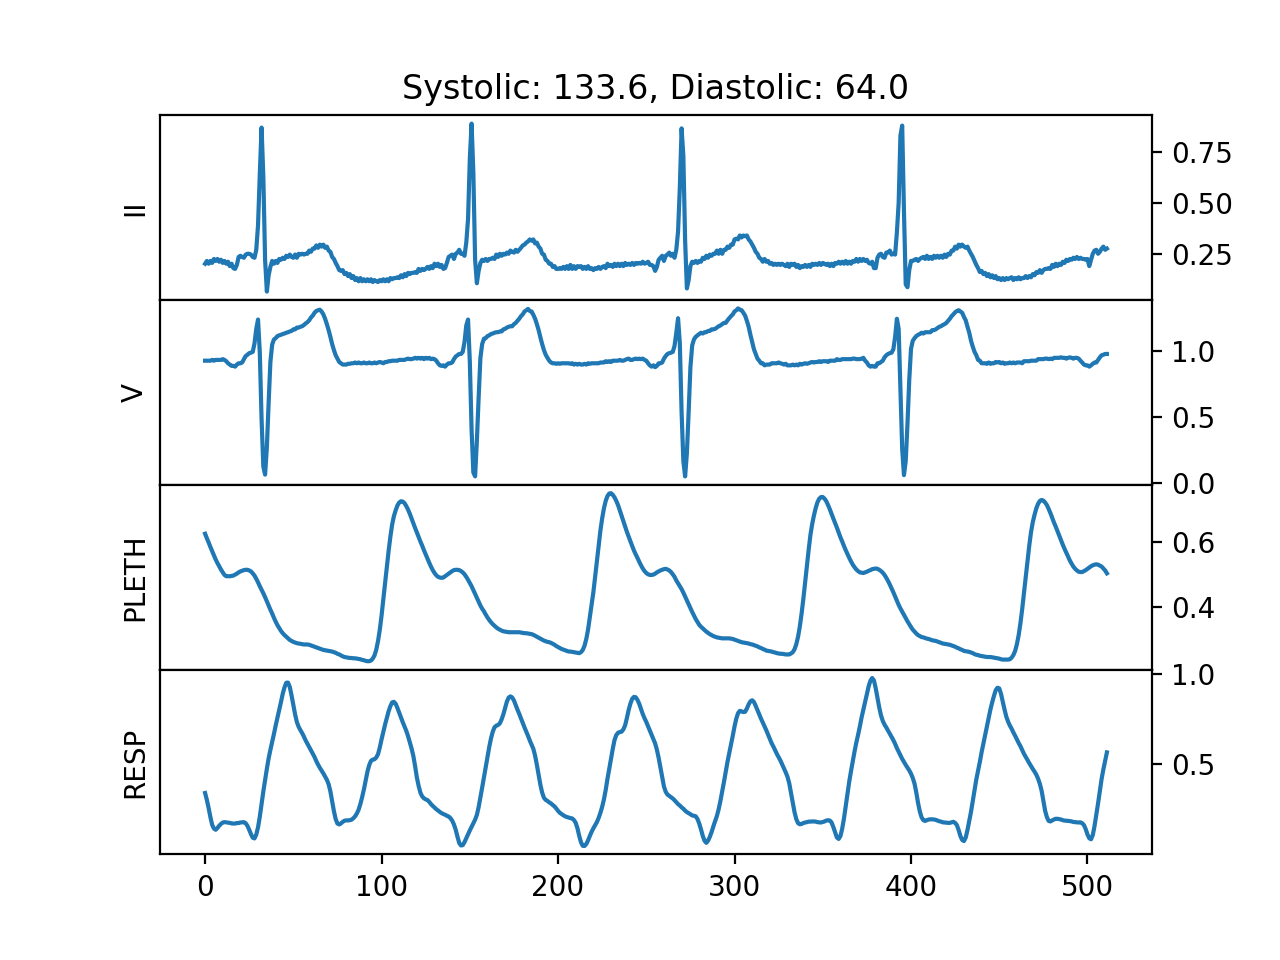

Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0


In [6]:
%matplotlib notebook
from matplotlib import pyplot

def plot_waves(x):
    pyplot.subplots_adjust(wspace=0, hspace=0)
    for i, sig in enumerate(prepare_data.INPUT_SIGS):
        ax = pyplot.subplot(len(prepare_data.INPUT_SIGS), 1, i + 1)
        ax.plot(x[:, i])
        ax.set_ylabel(sig)
        ax.yaxis.tick_right()

def plot_batch_example(x, y):
    fig = pyplot.figure()
    plot_waves(x)
    fig.axes[0].set_title('Systolic: %.1f, Diastolic: %.1f' % tuple(y.numpy()))
    
i, j = 4, 0

window_index_matrix = pipeline.get_window_index_matrix(H)

part = 'train'

windows = pipeline.get_windows(
    H['window_size'],
    window_index_matrix,
    tf.constant(epoch[part]['chunk_paths'][i],    dtype='string'),
    tf.constant(epoch[part]['sig_indices'][i],    dtype='int32'),
    tf.constant(epoch[part]['window_indices'][i], dtype='int32'),
    tf.constant(epoch[part]['baselines'][i],      dtype='int32'),
    tf.constant(epoch[part]['gains'][i],          dtype='float32'),   
)

x, y = list(windows)[j]
plot_batch_example(x, y)

In [6]:
model = conv_model.build(H)
model.summary()

Executing op __inference_keras_scratch_graph_15 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_20 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_25 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/

### Train

In [7]:
for i in range(100):
    
    epoch = {
        k: data_util.sample_epoch(H, metadata[v], sig_data[v])
        for k, v in partition.items()
    }

    data = {
        'train': pipeline.build(H, epoch['train']),
        'validation': pipeline.build(H, epoch['validation'])
    }
    
    model.fit(data['train'], shuffle=False)
    model.evaluate(data['validation'])

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Range in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GatherV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BroadcastTo in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/t

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:

Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
154/154 [==============================] - 43s 278ms/step - loss: 687.7658 - mean_absolute_error: 18.1104
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
154/154 [==============================] - 43s 277ms/step - loss: 679.2664 - mean_absolute_error: 17.6279
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/

154/154 [==============================] - 44s 285ms/step - loss: 729.1885 - mean_absolute_error: 18.1945
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
154/154 [==============================] - 43s 282ms/step - loss: 708.8404 - mean_absolute_error: 18.0433
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
154/154 [==============================] - 43s 280ms/step - loss: 687.9424 -

Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
154/154 [==============================] - 44s 285ms/step - loss: 719.1644 - mean_absolute_error: 17.9469
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
154/154 [==============================] - 43s 282ms/step - loss: 715.8129 - mean_absolute_error: 18.3027
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:

154/154 [==============================] - 43s 278ms/step - loss: 703.5486 - mean_absolute_error: 17.8168
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
154/154 [==============================] - 44s 286ms/step - loss: 715.7660 - mean_absolute_error: 18.1110
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
154/154 [==============================] - 42s 276ms/step - loss: 696.3068 -

Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
154/154 [==============================] - 43s 282ms/step - loss: 707.3502 - mean_absolute_error: 17.8804
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
154/154 [==============================] - 44s 287ms/step - loss: 692.4306 - mean_absolute_error: 17.6775
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:

154/154 [==============================] - 44s 288ms/step - loss: 737.1154 - mean_absolute_error: 18.4269
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
154/154 [==============================] - 43s 278ms/step - loss: 729.2232 - mean_absolute_error: 18.0953
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
154/154 [==============================] - 44s 286ms/step - loss: 690.5244 -

Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
154/154 [==============================] - 44s 284ms/step - loss: 704.7598 - mean_absolute_error: 18.0074
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelInterleaveDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FilterDataset in device /job:localhost/replica:0/task:0/device:CPU:0
154/154 [==============================] - 44s 286ms/step - loss: 708.5842 - mean_absolute_error: 18.0789


In [26]:
%%time

# logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

model.fit(data['train'].take(1000), shuffle=False)

1000/1000 [==============================] - 20s 20ms/step - loss: 924.5538 - mean_absolute_error: 21.4853
CPU times: user 54.2 s, sys: 4.25 s, total: 58.5 s
Wall time: 20 s


In [27]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 7s 14ms/step - loss: 1147.0859 - mean_absolute_error: 25.0163


[1147.085889984131, 25.016325]

In [22]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 12s 24ms/step - loss: 759.6275 - mean_absolute_error: 19.2325


[759.6274996337891, 19.232515]

In [19]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 12s 24ms/step - loss: 720.3194 - mean_absolute_error: 18.4570


[720.3194354248047, 18.456955]

In [16]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 12s 23ms/step - loss: 853.8424 - mean_absolute_error: 19.2554


[853.8424234313965, 19.255371]

In [13]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 12s 25ms/step - loss: 760.7378 - mean_absolute_error: 19.1564


[760.7377579345704, 19.156414]

In [11]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_8839 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 13s 26ms/step - loss: 758.2714 - mean_absolute_error: 19.6100


[758.2713509521484, 19.60996]

In [27]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 24s 47ms/step - loss: 753.3617 - mean_absolute_error: 18.8386


[753.3617384643554, 18.838564]

In [24]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 23s 46ms/step - loss: 729.2189 - mean_absolute_error: 18.4321


[729.2189436035156, 18.432133]

In [18]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 23s 46ms/step - loss: 747.6250 - mean_absolute_error: 18.7316


[747.6249995117188, 18.731619]

In [15]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 22s 43ms/step - loss: 811.4020 - mean_absolute_error: 19.5228


[811.4019518432617, 19.522778]

In [12]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 16s 32ms/step - loss: 913.2240 - mean_absolute_error: 20.426699


[913.2239967041015, 20.426598]

In [9]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_7482 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 16s 32ms/step - loss: 1024.6928 - mean_absolute_error: 22.3080


[1024.6928215637206, 22.308018]

In [13]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 22s 44ms/step - loss: 906.2998 - mean_absolute_error: 20.1188


[906.2998022460938, 20.118753]

In [10]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_10776 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 23s 46ms/step - loss: 749.8323 - mean_absolute_error: 18.5045


[749.8323179931641, 18.504505]

In [18]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 17s 33ms/step - loss: 949.9977 - mean_absolute_error: 19.5951


[949.9977275085449, 19.595083]

In [15]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 17s 35ms/step - loss: 826.7726 - mean_absolute_error: 19.0420


[826.7725655212403, 19.041985]

In [12]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_9895 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 17s 35ms/step - loss: 889.5058 - mean_absolute_error: 19.8435


[889.5058189697265, 19.843504]

In [25]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 22s 44ms/step - loss: 821.5610 - mean_absolute_error: 19.6693


[821.5610026245117, 19.669294]

In [22]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 16s 33ms/step - loss: 783.7218 - mean_absolute_error: 18.6581


[783.7217686767578, 18.658104]

In [20]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 23s 45ms/step - loss: 931.4061 - mean_absolute_error: 20.3897


[931.4060856933594, 20.38972]

In [15]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_10337 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 24s 47ms/step - loss: 769.6882 - mean_absolute_error: 18.8439


[769.6882013549805, 18.843912]

In [28]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 18s 36ms/step - loss: 737.2426 - mean_absolute_error: 19.4431


[737.24258303833, 19.443077]

In [25]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 18s 37ms/step - loss: 618.6063 - mean_absolute_error: 17.7994


[618.606300201416, 17.799446]

In [22]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 19s 37ms/step - loss: 622.5978 - mean_absolute_error: 17.2531


[622.5977668762207, 17.253124]

In [19]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 14s 29ms/step - loss: 658.0763 - mean_absolute_error: 17.7062


[658.0763165283203, 17.706244]

In [17]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 19s 37ms/step - loss: 686.3348 - mean_absolute_error: 18.3226


[686.3348303833008, 18.322563]

In [12]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 19s 38ms/step - loss: 650.8110 - mean_absolute_error: 17.9591


[650.8109704589843, 17.959131]

In [9]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_22508 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 20s 39ms/step - loss: 704.2708 - mean_absolute_error: 19.0280


[704.2707567749023, 19.027996]

In [25]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 20s 40ms/step - loss: 713.7286 - mean_absolute_error: 18.6703


[713.7286236572265, 18.670298]

In [22]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 20s 41ms/step - loss: 643.2724 - mean_absolute_error: 17.2592


[643.2724148864746, 17.259178]

In [19]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 20s 40ms/step - loss: 609.3809 - mean_absolute_error: 17.2555


[609.380864227295, 17.25551]

In [14]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 20s 40ms/step - loss: 696.7008 - mean_absolute_error: 19.0388


[696.7007549438476, 19.038767]

In [11]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_20358 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 21s 43ms/step - loss: 733.8006 - mean_absolute_error: 18.8906


[733.8005736083984, 18.890602]

In [24]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 17s 33ms/step - loss: 873.1853 - mean_absolute_error: 19.8677


[873.1852915039062, 19.867662]

In [21]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 17s 34ms/step - loss: 834.2781 - mean_absolute_error: 19.6484


[834.2780909729004, 19.64839]

In [18]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 15s 30ms/step - loss: 898.7054 - mean_absolute_error: 20.9029


[898.7054212646484, 20.902891]

In [15]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 16s 31ms/step - loss: 895.5552 - mean_absolute_error: 19.8500


[895.5551668701172, 19.85004]

In [12]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 16s 32ms/step - loss: 846.8025 - mean_absolute_error: 19.3607


[846.8024870605469, 19.360708]

In [9]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_7545 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 17s 34ms/step - loss: 1041.2534 - mean_absolute_error: 21.5447


[1041.2534257202149, 21.544691]

In [27]:
model.evaluate(data['validation'].take(1000))

1000/1000 [==============================] - 22s 22ms/step - loss: 915.5336 - mean_absolute_error: 21.1913


[915.533636352539, 21.191256]

In [24]:
model.evaluate(data['validation'].take(1000))

1000/1000 [==============================] - 20s 20ms/step - loss: 887.4507 - mean_absolute_error: 19.8303


[887.4507019958496, 19.83033]

In [20]:
model.evaluate(data['validation'].take(500))

500/500 [==============================] - 12s 24ms/step - loss: 903.0792 - mean_absolute_error: 19.2268


[903.0791560668945, 19.226809]

In [17]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_49089 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 11s 21ms/step - loss: 891.3354 - mean_absolute_error: 19.8597


[891.3353881835938, 19.859728]

In [12]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_27244 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 10s 19ms/step - loss: 912.4248 - mean_absolute_error: 19.7742


[912.4248034362793, 19.774185]

In [8]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_12474 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 11s 22ms/step - loss: 997.6162 - mean_absolute_error: 21.5830


[997.6161806640625, 21.583025]

In [85]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_448825 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 10s 19ms/step - loss: 1144.7412 - mean_absolute_error: 23.9406


[1144.7412332763672, 23.940613]

In [79]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_435189 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 29s 59ms/step - loss: 879.0042 - mean_absolute_error: 19.9111


[879.0042414550782, 19.911139]

In [73]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_418400 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 8s 16ms/step - loss: 1387.5463 - mean_absolute_error: 23.0640


[1387.5463156433104, 23.064003]

In [66]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_392889 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 8s 16ms/step - loss: 1034.8844 - mean_absolute_error: 21.4312


[1034.8844485473633, 21.43125]

In [62]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_373529 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 9s 17ms/step - loss: 805.6617 - mean_absolute_error: 19.1256


[805.6617344970703, 19.125616]

In [58]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_339169 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 10s 19ms/step - loss: 774.2665 - mean_absolute_error: 18.6308


[774.2664613952637, 18.630787]

In [48]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_312589 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 6s 13ms/step - loss: 1024.7010 - mean_absolute_error: 21.8848


[1024.701012802124, 21.884773]

In [43]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_299349 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 7s 14ms/step - loss: 989.3264 - mean_absolute_error: 21.4298


[989.326411605835, 21.429792]

In [21]:
model.evaluate(data['validation'].take(1000))

Executing op __inference_distributed_function_223132 in device /job:localhost/replica:0/task:0/device:GPU:0
1000/1000 [==============================] - 14s 14ms/step - loss: 790.5677 - mean_absolute_error: 19.7810


[790.5677110824585, 19.781044]

In [16]:
model.evaluate(data['validation'].take(1000))

Executing op __inference_distributed_function_119996 in device /job:localhost/replica:0/task:0/device:GPU:0
1000/1000 [==============================] - 12s 12ms/step - loss: 958.6640 - mean_absolute_error: 20.6542


[958.6640138015747, 20.654228]

In [13]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_18360 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 8s 15ms/step - loss: 787.2246 - mean_absolute_error: 19.1382


[787.2245676879883, 19.138231]

In [17]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_38918 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 8s 16ms/step - loss: 879.5961 - mean_absolute_error: 19.9608


[879.5960913391114, 19.960762]

In [9]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_18360 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 28s 57ms/step - loss: 808.3033 - mean_absolute_error: 19.3396


[808.3032637939453, 19.339571]

In [43]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_87938 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 7s 15ms/step - loss: 887.3882 - mean_absolute_error: 20.3980


[887.3881889038086, 20.397951]

In [39]:
model.evaluate(data['validation'].take(500))

Executing op __inference_distributed_function_53578 in device /job:localhost/replica:0/task:0/device:GPU:0
500/500 [==============================] - 8s 15ms/step - loss: 1113.4757 - mean_absolute_error: 23.2791


[1113.4756562194825, 23.279064]

In [36]:
model.evaluate(data['validation'].take(250))

300/300 [==============================] - 4s 15ms/step - loss: 1324.7082 - mean_absolute_error: 27.0149


[1324.70822458903, 27.014908]

### Constant 120/60 Prediction

In [38]:
x = tf.keras.layers.Input(shape=(H['window_size'], len(prepare_data.INPUT_SIGS)))
z = x[:2, 0, 0]
z *= tf.constant([0, 0], dtype='float32')
z += tf.constant([120, 60], dtype='float32')

const_model = tf.keras.models.Model(inputs=x, outputs=z)
const_model.compile(loss='mean_squared_error', metrics=['mean_absolute_error'])
const_model.evaluate(data['validation'].take(1000))

Executing op __inference_keras_scratch_graph_284472 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_284477 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_284482 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_284487 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_284492 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_distributed_function_284609 in device /job:localhost/replica:0/task:0/device:GPU:0
1000/1000 [==============================] - 5s 5ms/step - loss: 864.2235 - mean_absolute_error: 19.8517


[864.2235219192505, 19.851696]

In [13]:
data_util.calculate_training_speed(H, 5000, seconds_to_train=110)

248.2 days per hour


In [14]:
df = pandas.DataFrame([
    {'CPU count': 16, 'GPU count': 3, 'Format': 'flac',   'Windows': 10,   'Speed (days/hr)': 14},
    {'CPU count': 16, 'GPU count': 6, 'Format': 'flac',   'Windows': 10,   'Speed (days/hr)': 22},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'flac',   'Windows': 50,   'Speed (days/hr)': 65},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'flac',   'Windows': 1000, 'Speed (days/hr)': 107},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'flac',   'Windows': 1000, 'Speed (days/hr)': 182},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'zlib',   'Windows': 10,   'Speed (days/hr)': 24},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'zlib',   'Windows': 50,   'Speed (days/hr)': 93},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'zlib',   'Windows': 100,  'Speed (days/hr)': 112},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'serial', 'Windows': 10,   'Speed (days/hr)': 68},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'serial', 'Windows': 50,   'Speed (days/hr)': 178},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'serial', 'Windows': 100,  'Speed (days/hr)': 210},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'serial', 'Windows': 1000, 'Speed (days/hr)': 311},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'chunks', 'Windows': 10,   'Speed (days/hr)': 248},
    {'CPU count': 16, 'GPU count': 3, 'Format': 'memory', 'Windows': -1,   'Speed (days/hr)': 345},
    {'CPU count': 16, 'GPU count': 6, 'Format': 'memory', 'Windows': -1,   'Speed (days/hr)': 459},
])
df.sort_values('Speed (days/hr)')

,CPU count,GPU count,Format,Windows,Speed (days/hr)
0,16,3,flac,10,14
1,16,6,flac,10,22
5,16,3,zlib,10,24
2,16,3,flac,50,65
8,16,3,serial,10,68
6,16,3,zlib,50,93
3,16,3,flac,1000,107
7,16,3,zlib,100,112
9,16,3,serial,50,178
4,16,3,flac,1000,182


### Dummy Data in Memory

In [13]:
n_batches = 1000

tf.random.set_seed(7)
x = tf.random.uniform(
    shape = [n_batches, H['batch_size'], H['window_size'], len(H['input_sigs'])],
    minval = -1,
    maxval = 1,
)
y = tf.random.uniform(shape=[n_batches, H['batch_size'], 2], minval=40, maxval=200)
dummy_data = tf.data.Dataset.from_tensor_slices((x, y))
model = conv_model.build(H)

%time model.fit(dummy_data, shuffle=False)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_keras_scratch_graph_6295 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_6300 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_6305 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job: